# IPL ANALYSIS

### Import all the libraries

In [231]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Fetching data from JSON using Python

In [8]:
# Path where JSON files are stored
path = r"C:\Users\USER\Downloads\ipl_json"

# List all json files
files = [f for f in os.listdir(path) if f.endswith('.json')]

print("Total files:", len(files))
print("First 5 files:", files[:5])


Total files: 1169
First 5 files: ['1082591.json', '1082592.json', '1082593.json', '1082594.json', '1082595.json']


In [9]:
with open(os.path.join(path, files[0]), "r") as f:
    data = json.load(f)

print(data.keys())


dict_keys(['meta', 'info', 'innings'])


#### Data 1

In [50]:
all_matches = []

for filename in files:
    with open(os.path.join(path, filename), "r") as f:
        data = json.load(f)
        
        match_id = filename.replace(".json", "")
        season = data["info"].get("season", None)
        teams = data["info"]["teams"]
        
        # Loop through innings
        for inning in data["innings"]:
            batting_team = inning["team"]
            
            # Loop through overs
            for over in inning["overs"]:
                over_number = over["over"]
                
                # Loop through deliveries
                for delivery in over["deliveries"]:
                    row = {
                        "match_id": match_id,
                        "season": season,
                        "batting_team": batting_team,
                        "over": over_number,
                        "batsman": delivery["batter"],
                        "non_striker": delivery["non_striker"],
                        "bowler": delivery["bowler"],
                        "runs_batsman": delivery["runs"]["batter"],
                        "runs_extras": delivery["runs"]["extras"],
                        "runs_total": delivery["runs"]["total"],
                        "extras_detail": delivery.get("extras", None),
                        "wickets": delivery.get("wickets", None)
                    }
                    all_matches.append(row)

delivery = pd.DataFrame(all_matches)


In [115]:
import re

def clean_season(val):
    if pd.isna(val):
        return None
    val = str(val)
    x = re.match(r"(\d{4})", val)
    if x:
        return int(x.group(1))
    return None

In [116]:
delivery["season"] = delivery["season"].apply(clean_season)

### Saving & reviewing the fetched data delivery

In [117]:
delivery.sample()

,match_id,season,batting_team,over,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,extras_detail,wickets
68941,1254107,2021,Sunrisers Hyderabad,13,WP Saha,JO Holder,Harpreet Brar,1,0,1,None,None


In [118]:
delivery.to_csv("ipl_deliveries.csv", index=False)

In [119]:
print("Total rows:", delivery.shape[0])
print("Matches covered:", delivery['match_id'].nunique())
print("Seasons:", delivery['season'].unique())

Total rows: 278205
Matches covered: 1169
Seasons: [2017 2018 2019 2020 2021 2022 2023 2024 2025 2007 2009 2011 2012 2013
 2014 2015 2016]


#### Data 2

In [120]:
matches = []
for filename in files:
    with open(os.path.join(path, filename), "r") as f:
        data = json.load(f)

    # ---- MATCHES DATA ----
    info = data["info"]
    team1, team2 = info.get("teams", [None, None])
    
    matches.append({
        "match_id": filename.replace(".json", ""),
        "season": info.get("season"),
        "city": info.get("city"),
        "venue": info.get("venue"),
        "dates": info.get("dates"),
        "team1": team1,
        "team2": team2,
        "toss_winner": info["toss"].get("winner"),
        "toss_decision": info["toss"].get("decision"),
        "player_of_match": ", ".join(info.get("player_of_match") or []),
        "umpire1": (info.get("officials", {}).get("umpires") or info.get("umpires") or [None, None])[0],
        "umpire2": (info.get("officials", {}).get("umpires") or info.get("umpires") or [None, None])[1],
        "result": (
            f"{info['outcome']['winner']} won by {info['outcome']['by']['runs']} runs"
                if "runs" in info.get("outcome", {}).get("by", {}) else
            f"{info['outcome']['winner']} won by {info['outcome']['by']['wickets']} wickets"
                if "wickets" in info.get("outcome", {}).get("by", {}) else
            "No Result"
        ),
        "winner": info.get("outcome", {}).get("winner"),
        "by_runs": info.get("outcome", {}).get("by", {}).get("runs", 0),
        "by_wickets": info.get("outcome", {}).get("by", {}).get("wickets")
    })
    match=pd.DataFrame(matches)

In [123]:
match['season'] = match['season'].apply(clean_season)

### Saving & reviewing the fetched data matches

In [124]:
match.to_csv('ipl_matches.csv', index = False)

In [125]:
print("Total rows:", match.shape[0])
print("Matches covered:", match['match_id'].nunique())
print("Seasons:", match['season'].unique())

Total rows: 1169
Matches covered: 1169
Seasons: [2017 2018 2019 2020 2021 2022 2023 2024 2025 2007 2009 2011 2012 2013
 2014 2015 2016]


<b>So here we have dataset of both matches and ball by ball delivery of what happens at which ball.<br>
Now we can Exploratory data analysis and plot the graph of different comparisons.</b>

---

#### Sample of both datasets

In [126]:
match.sample()

,match_id,season,city,venue,dates,team1,team2,toss_winner,toss_decision,player_of_match,umpire1,umpire2,result,winner,by_runs,by_wickets
1129,980941,2016,Chandigarh,"Punjab Cricket Association IS Bindra Stadium, ...",[2016-04-25],Kings XI Punjab,Mumbai Indians,Kings XI Punjab,field,PA Patel,Nitin Menon,RJ Tucker,Mumbai Indians won by 25 runs,Mumbai Indians,25,NaN


In [127]:
delivery.sample()

,match_id,season,batting_team,over,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,extras_detail,wickets
103371,1359533,2023,Punjab Kings,3,P Simran Singh,LS Livingstone,AR Patel,0,0,0,None,None


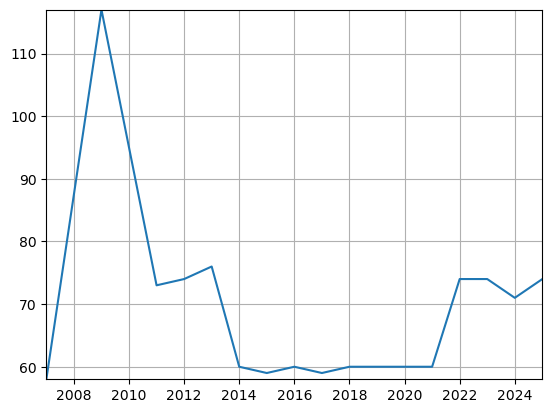

In [206]:
# Total matches per season

matches_per_season = match.groupby('season').size().reset_index(name='count')
plt.plot(matches_per_season['season'], matches_per_season['count'])
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.show()

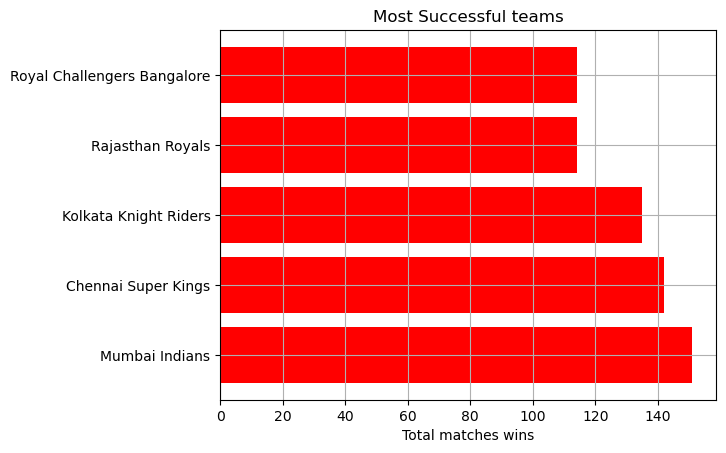

In [207]:
# Most successful team

most_wins= match['winner'].value_counts().head(5).reset_index(name='count')
plt.barh(most_wins['winner'], most_wins['count'], color='red')
plt.title('Most Successful teams')
plt.xlabel('Total matches wins')
plt.grid()
plt.show()

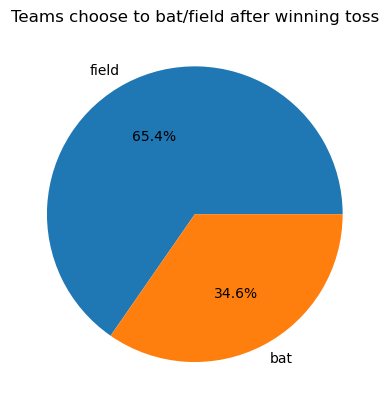

In [208]:
# toss decision is batting or bowling

toss_choice = match['toss_decision'].value_counts().reset_index(name='count')
plt.pie(toss_choice['count'], labels=toss_choice['toss_decision'], autopct='%1.1f%%')
plt.title('Teams choose to bat/field after winning toss')
plt.show()

In [209]:
delivery.sample()

,match_id,season,batting_team,over,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,extras_detail,wickets
18576,1136581,2018,Mumbai Indians,3,Ishan Kishan,SA Yadav,JC Archer,1,0,1,None,None


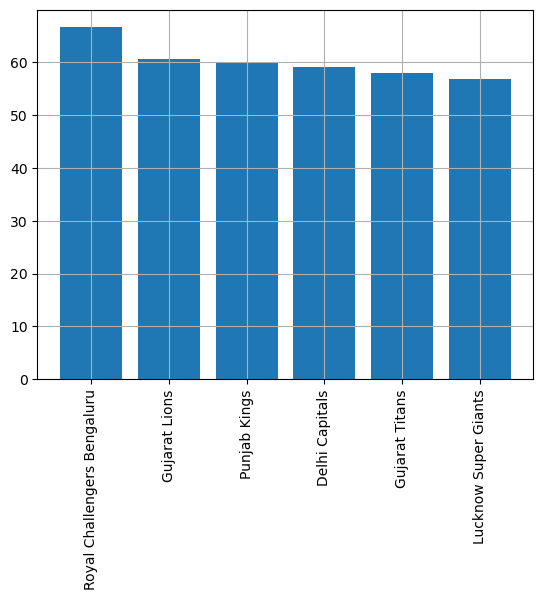

In [210]:
# Average powerplay runs (overs 1–6) by teams

overs = delivery[delivery['over'] <7]
powerplay_runs=overs.groupby(['match_id', 'batting_team'])['runs_total'].sum().groupby('batting_team').mean().sort_values(ascending=False).head(6).reset_index()
plt.bar(powerplay_runs['batting_team'], powerplay_runs['runs_total'])
plt.xticks(rotation='vertical')
plt.grid()
plt.show()

In [214]:
# Find the orange cap of every year (who scored maximum runs)

new =delivery.merge(match, left_on ='match_id', right_on ='match_id')
new = new.drop(columns=['season_x']).rename(columns={'season_y': 'season'})

In [226]:
orange_cap=(new.groupby(['season', 'batsman'])['runs_batsman'].sum()
    .sort_values(ascending=False).reset_index()
    .drop_duplicates(subset='season', keep='first')
    .sort_values('season'))
orange_cap

,season,batsman,runs_batsman
43,2007,SE Marsh,616
0,2009,SR Tendulkar,982
44,2011,CH Gayle,608
14,2012,CH Gayle,733
13,2013,MEK Hussey,733
27,2014,RV Uthappa,660
63,2015,DA Warner,562
1,2016,V Kohli,973
31,2017,DA Warner,641
12,2018,KS Williamson,735


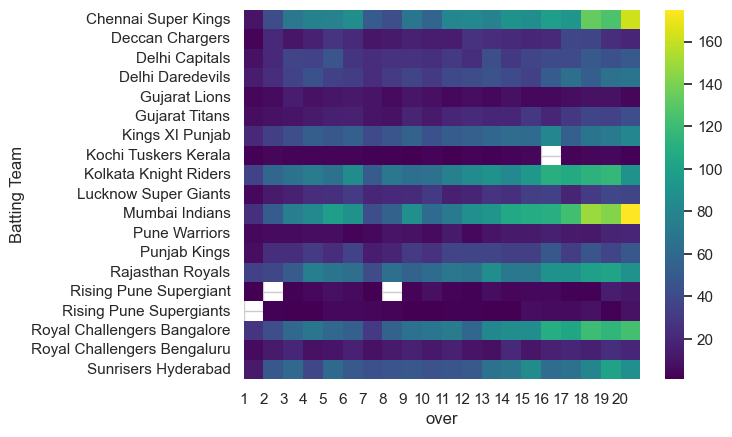

In [241]:
# Most sixes in which over

six =delivery[delivery['runs_batsman'] ==6]
graph =six.pivot_table(index ='over', columns='batting_team', values='runs_total', aggfunc ='count')

sns.heatmap(graph.T, cmap ='viridis')
plt.ylabel('Batting Team')
plt.xticks(ticks=range(20), labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.show()

### Observation
<ul>
    <li>Number of matches are highest in 2008 and 2009 and dropped then. In past 3 years average matches per season is 75</li>
    <li>Mumbai Indians and Chennai Super Kings have most wins means they are consistently strong teams</li>
    <li>Most teams choose fielding first even after winnning toss for reasons like
    <ul>
        <li>Chasing is usually considered easier (teams know the target).</li>
        <li>Due factors like dew at night, bowling becomes harder later, so captains prefer chasing.</li>
        <li>Short format (20 overs) → batting second allows more controlled aggression.</li>
    </ul></li>
    <li>RCB starts well in almost every match because their powerplay is best among all teams</li>
    <li>CSK and MI are most volatile teams in last 3 overs as they have highest number of sixes in last overs.</li>
</ul>